In [1]:
%load_ext autoreload
%autoreload 2

import pickle 

## This block downloads data. If it is already done, skip this block

In [ ]:
from datasets import load_dataset


# Load the dataset
comparisons_dataset = load_dataset("dataset/summarize_from_feedback", 'comparisons')
axis_dataset = load_dataset("dataset/summarize_from_feedback", 'axis')


 
# save data as pkl
with open('dataset/summarize_from_feedback/comparisons.pkl', 'wb') as handle: 
    pickle.dump(comparisons_dataset, handle)


with open('dataset/summarize_from_feedback/axis.pkl', 'wb') as handle: 
    pickle.dump(axis_dataset, handle) 

## Use this block if the data is already downloaded

In [3]:
with open('dataset/summarize_from_feedback/comparisons.pkl', 'rb') as handle: 
    comparisons_dataset = pickle.load(handle)


with open('dataset/summarize_from_feedback/axis.pkl', 'rb') as handle: 
    axis_dataset = pickle.load(handle) 

In [4]:
index = 1

axis_dataset['validation'][index]

{'info': {'id': 't3_4l0bal',
  'post': "Recently, my fiance  (20 m) and I (19f) moved into a new apartment with a mutual friend (20m) and somehow contracted scabies (don't know how). We've both been itchy af and have been to the doctor who confirmed that it was scabies for the both of us. Our room mate (20m) has not had symptoms of scabies bites appear yet but I have asked him to get treated as well and to treat his clothes and linen so that our apartment does not get reinfested after treatment.\n\nMy room mate refuses to buy the lotion needed to kill the mites on his skin (if there are any on him) and refuses to rewash and dry his linen and clothes. I'm scared that if he does not get treated the infestation of our apartment will not go away. I'm almost there to asking him to move out if he refuses treatment . He is not on the lease.",
  'title': '19f with fiance 20m and roommate 19m- fiance and I recently got infected with scabies and have started treatment, roommate refuses',
  'subr

In [9]:
import time
import progressbar
import known_metrics


def compare_metrics(data, metrics):
    bar = progressbar.ProgressBar(maxval=len(data)).start()
    bar_idx = 0

    metrics_results = []
    axes = []
    metrics_time = [0] * len(metrics)  # Initialize a list to store execution time for each metric

    for item in data:
        temp_result = {}

        for idx, metric in enumerate(metrics):
            start_time = time.time()  # Start timing
            score = metric(item['info']['post'], item['summary']['text'])
            temp_result[metric.__name__] = score
            metrics_time[idx] += time.time() - start_time  # Accumulate the execution time

        metrics_results.append(temp_result)
        axes.append(item['summary']['axes'])

        bar.update(bar_idx)
        bar_idx += 1
    bar.finish()

    return metrics_results, axes, metrics_time

# Example usage, assuming axis_dataset is properly defined and metrics are available
metrics_results, axes, metrics_time = compare_metrics(
    axis_dataset['validation'],
    [
        known_metrics.BLEU,
        known_metrics.ROUGE,
        # known_metrics.BERT_SCORE
    ]
)


print(metrics_time)  # This will print the total time taken by each metric


[1.9586498737335205, 22.636624097824097]


In [10]:
axes

[{'overall': 5,
  'accuracy': 5,
  'coverage': 6,
  'coherence': 5,
  'compatible': None},
 {'overall': 4,
  'accuracy': 4,
  'coverage': 4,
  'coherence': 7,
  'compatible': None},
 {'overall': 6,
  'accuracy': 6,
  'coverage': 6,
  'coherence': 7,
  'compatible': None},
 {'overall': 6,
  'accuracy': 6,
  'coverage': 6,
  'coherence': 7,
  'compatible': None},
 {'overall': 6,
  'accuracy': 5,
  'coverage': 7,
  'coherence': 7,
  'compatible': None},
 {'overall': 6,
  'accuracy': 7,
  'coverage': 6,
  'coherence': 7,
  'compatible': None},
 {'overall': 4,
  'accuracy': 4,
  'coverage': 4,
  'coherence': 7,
  'compatible': None},
 {'overall': 5,
  'accuracy': 5,
  'coverage': 5,
  'coherence': 7,
  'compatible': None},
 {'overall': 7,
  'accuracy': 7,
  'coverage': 7,
  'coherence': 7,
  'compatible': None},
 {'overall': 2,
  'accuracy': 4,
  'coverage': 2,
  'coherence': 6,
  'compatible': None},
 {'overall': 5,
  'accuracy': 5,
  'coverage': 6,
  'coherence': 7,
  'compatible': None},

In [11]:
import pandas as pd


def extract_metric(metrics, name=''):
    flat_result = {}
    if isinstance(metrics, dict):
        for metric, values in metrics.items():
            flat_result.update(extract_metric(values, f'{name}_{metric}'))
    else:
        flat_result[name[1:]] = metrics
    return flat_result


def flatten_metrics_results(metrics_results):
    """Flattens the metrics results into a list of dictionaries, where each dictionary corresponds to a single data point."""
    flattened_results = []
    for result in metrics_results:
        flattened_results.append(extract_metric(result))
    return flattened_results


def get_correlation_matrix(metrics):
    '''
    принимает список словарей. Словари могут быть любой глубины вложенности и бдут разложенны рекурсивно
    '''
    frames = [pd.DataFrame(flatten_metrics_results(metric)) for metric in metrics]
    combined_df = pd.concat([frame.reset_index(drop=True) for frame in frames], axis=1)

    return combined_df.corr(method='pearson'), combined_df

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_matrix(correlation_matrix):
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                square=True, cbar_kws={"shrink": .5})

    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")  # Rotate the x labels for better readability
    plt.yticks(rotation=0)  # Keep the y labels as is
    plt.tight_layout()  # Adjust layout to not cut off labels

    # Show the plot
    plt.show()

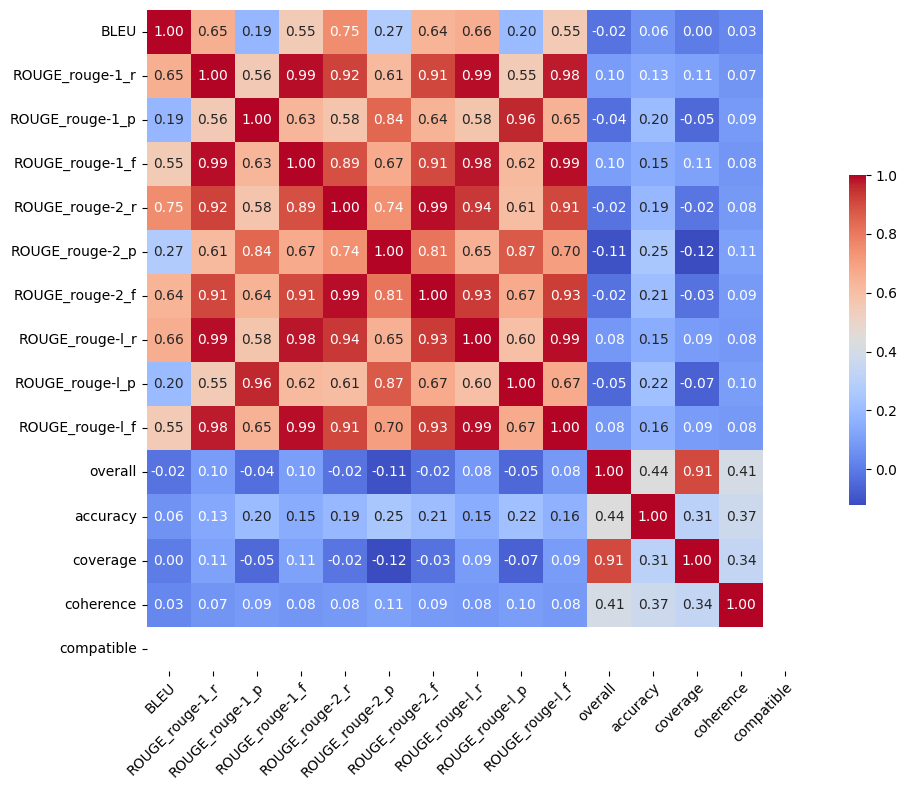

In [13]:
# Calculate Pearson correlation matrix
correlation_matrix, metrics_df = get_correlation_matrix([metrics_results, axes])

plot_correlation_matrix(correlation_matrix)

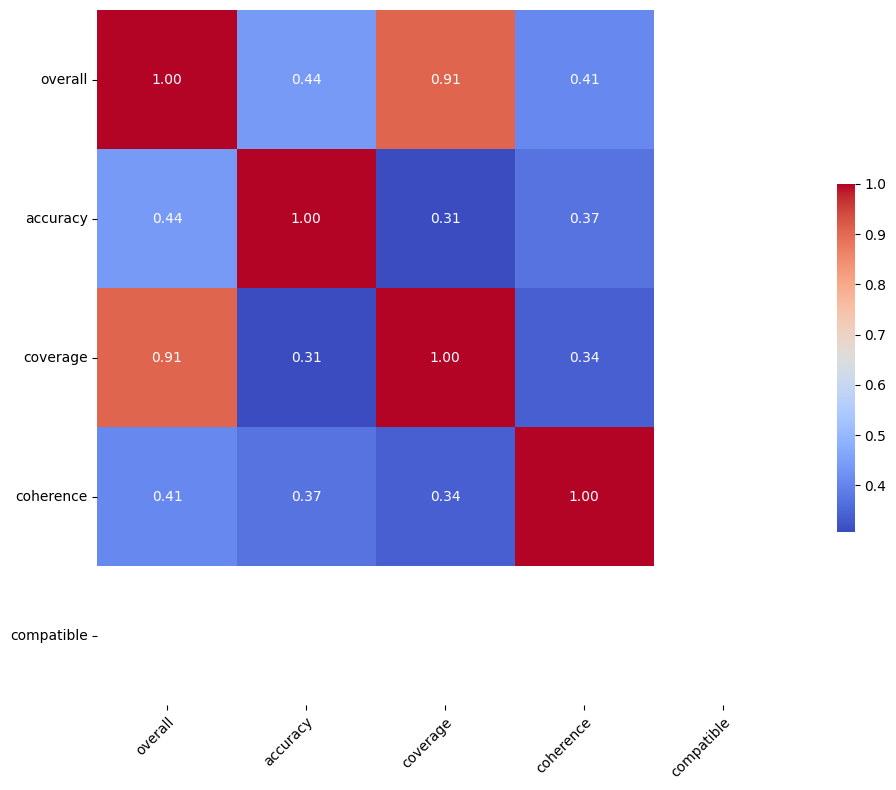

In [14]:
# Calculate Pearson correlation matrix
correlation_matrix, metrics_df = get_correlation_matrix([axes])

plot_correlation_matrix(correlation_matrix)

In [49]:
import custom_metric

word_clusters_in, clusters_in, _, _, embeddings_in = custom_metric.score_v1(axis_dataset['validation'][0]['info']['post'])
word_clusters_out, clusters_out, _, _, embeddings_out = custom_metric.score_v1(axis_dataset['validation'][0]['summary']['text'])

In [54]:
with open('analytics/sff_axes_word_clusters.txt', 'a') as file:
    file.write(f'INPUT:\n')
    for cluster in word_clusters_in:
        file.write(f'\t{cluster}\n')
    file.write(f'\n\nOUTPUT:\n')
    for cluster in word_clusters_out:
        file.write(f'\t{cluster}\n')


In [15]:
def one_way_dict(text):
    word_clusters, clusters, cos_sim_matrix, tokens, embeddings = custom_metric.score_v1(text)
    return {
        'word_cluster': word_clusters,
        'clusters': clusters,
        'cos_sim_matrix': cos_sim_matrix,
        'tokens': tokens,
        'embeddings': embeddings
    }


def custom_metric_helper(input, output):
    return {
        'input': one_way_dict(input),
        'output': one_way_dict(output)
    }


In [56]:
metrics_results, axes, metrics_time = compare_metrics(
    axis_dataset['validation'],
    [
        custom_metric_helper
    ]
)

100% |########################################################################|


In [59]:
with open('dataset/summarize_from_feedback/clasters_results.pkl', 'wb') as handle: 
    pickle.dump(metrics_results, handle)
    pickle.dump(axes, handle)
    pickle.dump(metrics_time, handle)


In [16]:
with open('dataset/summarize_from_feedback/clasters_results.pkl', 'rb') as handle: 
    metrics_results = pickle.load(handle)
    axes = pickle.load(handle)
    metrics_time = pickle.load(handle)



In [34]:
metrics_results[0]

{'custom_metric_helper': {'input': {'word_cluster': [['[CLS]'],
    ['recently'],
    ['fiance'],
    ['20', '19', '20', '20'],
    ['20', '19', '20', '20'],
    ['##f'],
    ['moved'],
    ['new'],
    ['apartment', 'apartment', 'apartment'],
    ['mutual'],
    ['friend'],
    ['20', '19', '20', '20'],
    ['somehow'],
    ['contracted'],
    ['sc', 'sc', 'sc'],
    ['##abi', '##abi', '##abi'],
    ['##es', '##es', '##es'],
    ['know'],
    ['##chy'],
    ['af'],
    ['doctor'],
    ['confirmed'],
    ['sc', 'sc', 'sc'],
    ['##abi', '##abi', '##abi'],
    ['##es', '##es', '##es'],
    ['us'],
    ['room', 'room'],
    ['mate', 'mate'],
    ['20', '19', '20', '20'],
    ['symptoms'],
    ['sc', 'sc', 'sc'],
    ['##abi', '##abi', '##abi'],
    ['##es', '##es', '##es'],
    ['bites'],
    ['appear'],
    ['yet'],
    ['asked'],
    ['get', 'get'],
    ['treated', 'treated', 'treatment'],
    ['well'],
    ['treat'],
    ['clothes', 'linen', 'clothes'],
    ['clothes', 'linen', 'line

In [47]:
import numpy as np

# RACM_ItoO -> ratio of average cosine matrices
def racm_itoo(in_data, out_data):
    return np.mean(in_data['cos_sim_matrix']) / np.mean(out_data['cos_sim_matrix'])

racm_itoo(metrics_results[0]['custom_metric_helper']['input'],
          metrics_results[0]['custom_metric_helper']['output'])

0.7631653

In [45]:
import numpy as np


def average_cluster_length(lst):
    num_sublists = len(lst)
    total_length = sum(len(sublist) for sublist in lst)

    return total_length / num_sublists if num_sublists > 0 else 0


# RACL_ItoO -> ratio of average cluster lengths
def racl_itoo(in_data, out_data):
    return average_cluster_length(in_data['clusters']) / average_cluster_length(out_data['clusters'])


racl_itoo(metrics_results[0]['custom_metric_helper']['input'],
          metrics_results[0]['custom_metric_helper']['output'])

1.554

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
import torch


# CDSE -> cosine distance between sum of embeddings
def cdse(in_data, out_data):
    return cosine_similarity(
        [torch.sum(in_data['embeddings'], dim=0)],
        [torch.sum(out_data['embeddings'], dim=0)]
    )


print(cdse(metrics_results[0]['custom_metric_helper']['input'],
           metrics_results[0]['custom_metric_helper']['output']))

[[0.9358447]]
[[0.93584466]]


In [81]:

# MCDEE -> mean cosine distance between each in and out embeddings
def mcdee(in_data, out_data):
    return np.mean(cosine_similarity(in_data['embeddings'], out_data['embeddings']))


mcdee(metrics_results[0]['custom_metric_helper']['input'],
      metrics_results[0]['custom_metric_helper']['output'])

0.39263025

In [87]:
# MSDER_ItoO -> mean SD of embeddings by raw, ration input to output
def msder_itoo(in_data, out_data):
    return torch.mean(torch.std(in_data['embeddings'], dim=1)) / torch.mean(torch.std(out_data['embeddings'], dim=1))


# MSDEC_ItoO -> mean SD of embeddings by cal, ration input to output
def msdec_itoo(in_data, out_data):
    return torch.mean(torch.std(in_data['embeddings'], dim=0)) / torch.mean(torch.std(out_data['embeddings'], dim=0))

In [93]:
# RNC_ItoO -> ratio number of clusters

def rnc_itoo(in_data, out_data):
    return len(in_data['clusters']) / len(out_data['clusters'])


rnc_itoo(metrics_results[0]['custom_metric_helper']['input'],
      metrics_results[0]['custom_metric_helper']['output'])

0.2625

In [108]:




def ff(in_data, out_data):
    clusters_sum_in = []

    max_len = 0
    for indices in in_data['clusters']:
        max_len = max(len(indices), max_len)

    for indices in in_data['clusters']:
        if len(indices) > max_len - 2:
            clusters_sum_in.append(torch.sum(in_data['embeddings'][indices], dim=0))
    
    clusters_sum_out = [torch.sum(out_data['embeddings'], dim=0)]

    return np.mean(cosine_similarity(clusters_sum_in, clusters_sum_out))


ff(metrics_results[0]['custom_metric_helper']['input'],
   metrics_results[0]['custom_metric_helper']['output'])

0.59854984

In [109]:
V1 = []

for v1_res in metrics_results:
    in_data = v1_res['custom_metric_helper']['input']
    out_data = v1_res['custom_metric_helper']['output']

    V1.append({
        'RACM_ItoO': racm_itoo(in_data, out_data),
        'RACL_ItoO': racl_itoo(in_data, out_data),
        'CDSE': cdse(in_data, out_data),
        # 'MCDEE': mcdee(in_data, out_data)
        'MSDER_ItoO': msder_itoo(in_data, out_data),
        'MSDEC_ItoO': msdec_itoo(in_data, out_data),
        'RNC_ItoO': rnc_itoo(in_data, out_data),
        'FF': ff(in_data, out_data)
    })

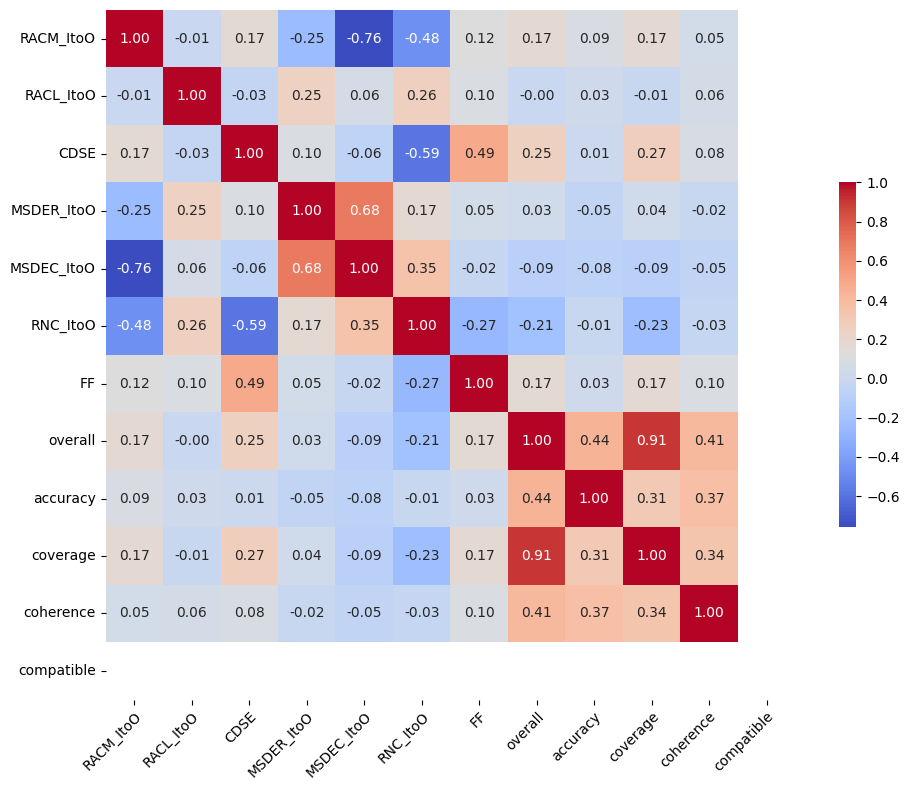

In [110]:
# Calculate Pearson correlation matrix
correlation_matrix, metrics_df = get_correlation_matrix([V1, axes])

plot_correlation_matrix(correlation_matrix)